In [85]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
data = pd.read_csv('datasets/ml-100k/u.data', sep='\t', header=None)

data.columns = ['user_id', 'item_id', 'rating', 'timestamp']

data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [87]:
R_df = data.pivot(index='user_id', columns='item_id', values='rating')

R_df = R_df.fillna(0)

R = sparse.csr_matrix(R_df.values)

print(f"Rating matrix shape: {R.shape}")
print(f"Sparsity: {R.nnz / (R.shape[0] * R.shape[1]):.4f}")

Rating matrix shape: (943, 1682)
Sparsity: 0.0630


In [88]:
def init_matrix_factorization(R, n_factors=20, seed=42):
    np.random.seed(seed)
    n_users, n_items = R.shape
    
    U = np.random.normal(0, 0.1, (n_users, n_factors))
    V = np.random.normal(0, 0.1, (n_items, n_factors))
    
    return U, V

In [89]:
def calculate_rmse(R, U, V):

    users, items = R.nonzero()    

    predictions = np.sum(U[users] * V[items], axis=1)
    
    actuals = R[users, items].A.flatten()
    
    rmse = np.sqrt(np.mean((actuals - predictions) ** 2))
    
    return rmse

In [90]:
def als_matrix_factorization(R, n_factors=20, lambda_reg=0.1, n_iterations=20, verbose=True) -> tuple[np.ndarray, np.ndarray, list[float]]:
    U, V = init_matrix_factorization(R, n_factors)
    n_users, n_items = R.shape
    
    I = np.eye(n_factors)
    
    train_errors = []
    
    for iteration in range(n_iterations):
        for i in range(n_users):
            rated_items = R[i].nonzero()[1]
            
            if len(rated_items) == 0:
                continue
                
            ratings = R[i, rated_items].toarray()[0]
            
            V_j = V[rated_items, :]
            
            U[i] = np.linalg.solve(V_j.T @ V_j + lambda_reg * I, V_j.T @ ratings.transpose()).transpose()
        
        for j in range(n_items):
            rating_users = R[:, j].nonzero()[0]
            
            if len(rating_users) == 0:
                continue
                
            ratings = R[rating_users, j].toarray().flatten()
    
            U_i = U[rating_users, :]
            
            V[j] = np.linalg.solve(U_i.T @ U_i + lambda_reg * I, U_i.T @ ratings.transpose()).transpose()
        
        # Calculate training error
        train_rmse = calculate_rmse(R, U, V)
        train_errors.append(train_rmse)
        
        if verbose and (iteration + 1) % 1 == 0:
            print(f"Iteration {iteration+1}/{n_iterations} - RMSE: {train_rmse:.4f}")
    
    return U, V, train_errors

In [91]:
def partial_als_matrix_factorization(user_id, R, U, V, n_factors=20, lambda_reg=0.1) -> np.ndarray:
    I = np.eye(n_factors)
    
    rated_items = R[user_id].nonzero()[1]
        
    ratings = R[user_id, rated_items].toarray()[0]
    
    V_j = V[rated_items, :]
    
    U[user_id] = np.linalg.solve(V_j.T @ V_j + lambda_reg * I, V_j.T @ ratings.transpose()).transpose()

    train_rmse = calculate_rmse(R, U, V)
    print(f"Train Error: {train_rmse}")

    return U


In [92]:
def predict(user_id, item_id, U, V, min_rating=1, max_rating=5):
    raw_prediction = U[user_id] @ V[item_id].T
    range_size = max_rating - min_rating
    return min_rating + range_size * (1 / (1 + np.exp(-raw_prediction)))

In [93]:
def recommend_items(user_id, U, V, R, top_n=10, exclude_rated=True, min_rating=1, max_rating=5):
    predictions = U[user_id] @ V.T
    range_size = max_rating - min_rating
    predictions = min_rating + range_size * (1 / (1 + np.exp(-predictions)))


    # If exclude_rated is True, set the predictions for already rated items to -inf
    if exclude_rated:
        rated_items = R[user_id].nonzero()[1]
        predictions[rated_items] = -np.inf
    
    # Get top N item indices
    top_item_indices = np.argsort(predictions)[::-1][:top_n]
    
    # Create list of (item_id, predicted_rating) tuples
    recommendations = [(item_id, predictions[item_id]) for item_id in top_item_indices]
    
    return recommendations

In [110]:
# Train the ALS model
n_factors = 100
lambda_reg = 1
n_iterations = 20

# Create a mapping from original user/item IDs to matrix indices
user_id_map = {id: i for i, id in enumerate(R_df.index)}
item_id_map = {id: i for i, id in enumerate(R_df.columns)}
# Reverse mapping for recommendations
reverse_item_id_map = {i: id for id, i in item_id_map.items()}

# Train the model
U, V, train_errors = als_matrix_factorization(R, n_factors, lambda_reg, n_iterations, verbose=True)

Iteration 1/20 - RMSE: 0.5606
Iteration 2/20 - RMSE: 0.2752
Iteration 3/20 - RMSE: 0.1895
Iteration 4/20 - RMSE: 0.1535
Iteration 5/20 - RMSE: 0.1347
Iteration 6/20 - RMSE: 0.1234
Iteration 7/20 - RMSE: 0.1160
Iteration 8/20 - RMSE: 0.1108
Iteration 9/20 - RMSE: 0.1070
Iteration 10/20 - RMSE: 0.1041
Iteration 11/20 - RMSE: 0.1018
Iteration 12/20 - RMSE: 0.0999
Iteration 13/20 - RMSE: 0.0984
Iteration 14/20 - RMSE: 0.0971
Iteration 15/20 - RMSE: 0.0959
Iteration 16/20 - RMSE: 0.0949
Iteration 17/20 - RMSE: 0.0941
Iteration 18/20 - RMSE: 0.0933
Iteration 19/20 - RMSE: 0.0926
Iteration 20/20 - RMSE: 0.0919


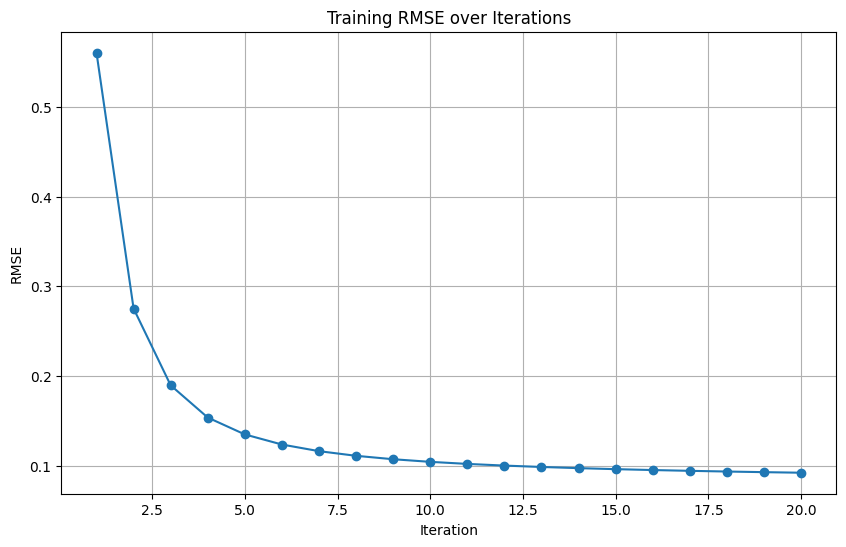

In [111]:
# Plot the training RMSE over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), train_errors, marker='o')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training RMSE over Iterations')
plt.grid(True)
plt.show()

In [112]:
# Get original user ID (for example, user #1)
original_user_id = 4

# Convert to matrix index
if original_user_id in user_id_map:
    matrix_user_id = user_id_map[original_user_id]
    
    # Get recommendations
    recommendations = recommend_items(matrix_user_id, U, V, R, top_n=10)
    
    print(f"Top 10 item recommendations for user {original_user_id}:")
    for i, (item_idx, pred_rating) in enumerate(recommendations):
        # Convert matrix index back to original item ID
        original_item_id = reverse_item_id_map[item_idx]
        print(f"{i+1}. Item {original_item_id}: Predicted rating = {pred_rating:.2f}")
else:
    print(f"User ID {original_user_id} not found in the dataset")

Top 10 item recommendations for user 4:
1. Item 302: Predicted rating = 4.97
2. Item 270: Predicted rating = 4.95
3. Item 326: Predicted rating = 4.94
4. Item 990: Predicted rating = 4.94
5. Item 309: Predicted rating = 4.94
6. Item 889: Predicted rating = 4.94
7. Item 205: Predicted rating = 4.93
8. Item 904: Predicted rating = 4.93
9. Item 748: Predicted rating = 4.93
10. Item 872: Predicted rating = 4.93


In [113]:
def add_rating(user_id, item_ids, ratings, R):
    user_id = user_id_map[user_id]
    item_ids = [item_id_map[item_id] for item_id in item_ids]
    for item_id, rating in zip(item_ids, ratings):
        R[user_id, item_id] = rating
    U_updated= partial_als_matrix_factorization(user_id, R, U, V, n_factors, lambda_reg)
    return U_updated



In [114]:
U_updated = add_rating(4, [318, 306, 172, 659, 292, 990], [1, 1, 1, 1, 1, 1], R)

Train Error: 0.09208826316758072


/Users/narly/Code/projects/ALS-RecSys-for-movies/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [115]:
if original_user_id in user_id_map:
    matrix_user_id = user_id_map[original_user_id]
    
    # Get recommendations
    recommendations = recommend_items(matrix_user_id, U_updated, V, R, top_n=10)
    
    print(f"Top 10 item recommendations for user {original_user_id}:")
    for i, (item_idx, pred_rating) in enumerate(recommendations):
        # Convert matrix index back to original item ID
        original_item_id = reverse_item_id_map[item_idx]
        print(f"{i+1}. Item {original_item_id}: Predicted rating = {pred_rating:.2f}")
else:
    print(f"User ID {original_user_id} not found in the dataset")

Top 10 item recommendations for user 4:
1. Item 205: Predicted rating = 4.97
2. Item 423: Predicted rating = 4.95
3. Item 347: Predicted rating = 4.95
4. Item 302: Predicted rating = 4.94
5. Item 73: Predicted rating = 4.94
6. Item 1016: Predicted rating = 4.93
7. Item 343: Predicted rating = 4.93
8. Item 346: Predicted rating = 4.93
9. Item 748: Predicted rating = 4.92
10. Item 270: Predicted rating = 4.92
